In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
from glob import glob
import sys
import random
from random import sample

from tqdm import tqdm_notebook
# from tqdm.notebook import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
#from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import jaccard_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset

from PIL import Image

# Image Preparation

The following image preparation was taken almost verbatim from another excellent kernel of the TGS Salt Identification challenge: https://www.kaggle.com/jesperdramsch/intro-to-seismic-salt-and-how-to-geophysics. I take no credit for it.  

In [2]:
# Set some parameters# Set s 
im_width = 128
im_height = 128
im_chan = 1
path_train = './external/salt/train'
path_test = './external/salt/test'

train_path_images = os.path.abspath(path_train + "/images/")
train_path_masks = os.path.abspath(path_train + "/masks/")

test_path_images = os.path.abspath(path_test + "/images/")
test_path_masks = os.path.abspath(path_test + "/masks/")

In [3]:
train_path_images_list = glob(os.path.join(train_path_images, "*.png"))
train_path_masks_list = glob(os.path.join(train_path_masks, "*.png"))
test_path_images_list = glob(os.path.join(test_path_images, "*.png"))
test_path_masks_list = glob(os.path.join(test_path_masks, "*.png"))

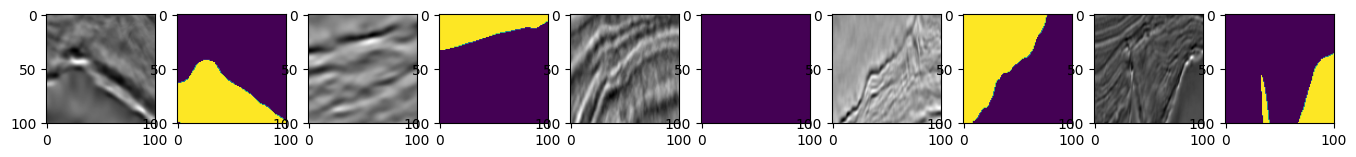

In [4]:
demos = []
for filename in os.listdir(train_path_images):
    if filename.endswith((".png", ".jpg", ".jpeg", ".bmp")):
        demos.append(filename) 
ids = sample(demos, 5)
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = imread(train_path_images + "/" + img_name)
    img_mask = imread(train_path_masks + "/" + img_name)
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

In [5]:
train_ids = next(os.walk(train_path_images))[2]
test_ids = next(os.walk(test_path_images))[2]

In [6]:
# Get and resize train images and masks
# X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
# np.uint32
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint32)
Y_train = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.bool_)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    img = imread(path_train + '/images/' + id_)
    x = resize(img, (128, 128, 1), mode='constant', preserve_range=True)
    X_train[n] = x
    mask = imread(path_train + '/masks/' + id_)
    Y_train[n] = resize(mask, (128, 128, 1), 
                        mode='constant', 
                        preserve_range=True)

print('Done!')

Getting and resizing train images and masks ... 


/tmp/ipykernel_12562/3349001864.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):


  0%|          | 0/4000 [00:00<?, ?it/s]

Done!


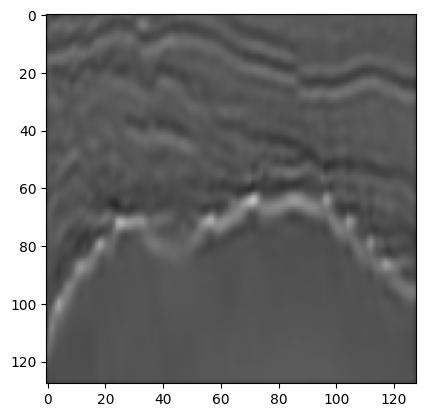

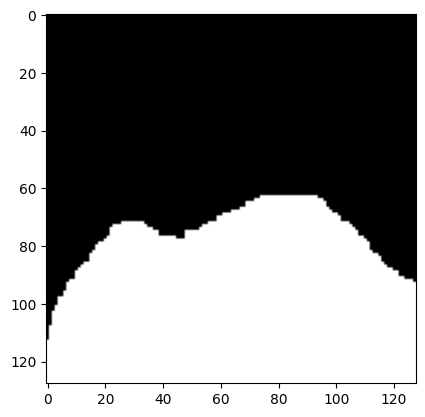

In [7]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Prepare Images for Pytorch

The following is what allows us to easily use our with Pytorch. We create a class with the following methods which then allows us to use a DataLoader.

In [8]:
# https://stackoverflow.com/questions/50052295/how-do-you-load-images-into-pytorch-dataloader
class saltIDDataset(torch.utils.data.Dataset):

    def __init__(self,preprocessed_images,train=True, preprocessed_masks=None):
        """
        Args:
            text_file(string): path to text file
            root_dir(string): directory with all train images
        """
        self.train = train
        self.images = preprocessed_images
        if self.train:
            self.masks = preprocessed_masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = None
        if self.train:
            mask = self.masks[idx]
        return (image, mask)

In [9]:
DATA_PATH = './external/salt/'
IMAGE_PATH      = 'train/images/'
MASK_PATH       = 'train/masks/'
INPUT_SIZE = 128
class TGSDataset(Dataset):
    """TGS Salt Identification dataset."""
    
    def __init__(self, root_dir=DATA_PATH, transform=None):
        """
        Args:
            root_path (string): Directory with all the images.
            transformer (function): whether to apply the data augmentation scheme
                mentioned in the paper. Only applied on the train split.
        """

        # load dataset from root dir
        train_df  = pd.read_csv(root_dir+'train.csv', index_col='id')
        depths_df = pd.read_csv(root_dir+'depths.csv', index_col='id')
        train_df = train_df.join(depths_df)

        self.root_dir   = root_dir
        self.ids        = train_df.index
        self.depths     = train_df['z'].to_numpy()
        self.rle        = train_df['rle_mask'].to_numpy()
        if transform is None:
            self.transfrom = transforms.Compose([transforms.Resize((INPUT_SIZE, INPUT_SIZE)), 
                                                  transforms.Grayscale(), 
                                                  transforms.ToTensor(),])
    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        id    = self.ids[index]
        depth = self.depths[index]

        # file should be unzipped
        image = Image.open(self.root_dir+IMAGE_PATH+id+'.png')
        mask  = Image.open(self.root_dir+MASK_PATH+id+'.png')
    
        image = self.transfrom(image)
        mask  = self.transfrom(mask)

        return image, mask


In [10]:
X_train_shaped = X_train.reshape(-1, 1, 128, 128)/255
Y_train_shaped = Y_train.reshape(-1, 1, 128, 128)

In [11]:
X_train_shaped = X_train_shaped.astype(np.float32)
Y_train_shaped = Y_train_shaped.astype(np.float32)

We set a random seed for reproducibility.

In [12]:
torch.cuda.manual_seed_all(4200)
np.random.seed(133700)

In [13]:
indices = list(range(len(X_train_shaped)))
np.random.shuffle(indices)

val_size = 1/10
split = np.int_(np.floor(val_size * len(X_train_shaped)))

train_idxs = indices[split:]
val_idxs = indices[:split]

You may need to tweak your batch_size based on how much memory you have on your GPU.

In [14]:
salt_ID_dataset_train = saltIDDataset(X_train_shaped[train_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[train_idxs])
salt_ID_dataset_val = saltIDDataset(X_train_shaped[val_idxs], 
                                      train=True, 
                                      preprocessed_masks=Y_train_shaped[val_idxs])

batch_size = 16

train_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=salt_ID_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=False)

# Define U-Net Model

Here's the meat of the kernel, where we define our U-Net architecture. See also this excellent kernel from an older challenge: https://www.kaggle.com/mlagunas/naive-unet-with-pytorch-tensorboard-logging.

In [15]:
class double_conv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(inplace=True))
        
    def forward(self, x):
        x = self.conv(x)
        return x
        
start_fm = 16

class Unet(nn.Module):
    
    def __init__(self):
        super(Unet, self).__init__()
        
        # Input 128x128x1
        
        #Contracting Path
        
        #(Double) Convolution 1        
        self.double_conv1 = double_conv(1, start_fm, 3, 1, 1)
        #Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 2
        self.double_conv2 = double_conv(start_fm, start_fm * 2, 3, 1, 1)
        #Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 3
        self.double_conv3 = double_conv(start_fm * 2, start_fm * 4, 3, 1, 1)
        #Max Pooling 3
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 4
        self.double_conv4 = double_conv(start_fm * 4, start_fm * 8, 3, 1, 1)
        #Max Pooling 4
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        #Convolution 5
        self.double_conv5 = double_conv(start_fm * 8, start_fm * 16, 3, 1, 1)
        
        #Transposed Convolution 4
        self.t_conv4 = nn.ConvTranspose2d(start_fm * 16, start_fm * 8, 2, 2)
        # Expanding Path Convolution 4 
        self.ex_double_conv4 = double_conv(start_fm * 16, start_fm * 8, 3, 1, 1)
        
        #Transposed Convolution 3
        self.t_conv3 = nn.ConvTranspose2d(start_fm * 8, start_fm * 4, 2, 2)
        #Convolution 3
        self.ex_double_conv3 = double_conv(start_fm * 8, start_fm * 4, 3, 1, 1)
        
        #Transposed Convolution 2
        self.t_conv2 = nn.ConvTranspose2d(start_fm * 4, start_fm * 2, 2, 2)
        #Convolution 2
        self.ex_double_conv2 = double_conv(start_fm * 4, start_fm * 2, 3, 1, 1)
        
        #Transposed Convolution 1
        self.t_conv1 = nn.ConvTranspose2d(start_fm * 2, start_fm, 2, 2)
        #Convolution 1
        self.ex_double_conv1 = double_conv(start_fm * 2, start_fm, 3, 1, 1)
        
        # One by One Conv
        self.one_by_one = nn.Conv2d(start_fm, 1, 1, 1, 0)
        #self.final_act = nn.Sigmoid()
        
        
    def forward(self, inputs):
        # Contracting Path
        conv1 = self.double_conv1(inputs)
        maxpool1 = self.maxpool1(conv1)

        conv2 = self.double_conv2(maxpool1)
        maxpool2 = self.maxpool2(conv2)

        conv3 = self.double_conv3(maxpool2)
        maxpool3 = self.maxpool3(conv3)

        conv4 = self.double_conv4(maxpool3)
        maxpool4 = self.maxpool4(conv4)
            
        # Bottom
        conv5 = self.double_conv5(maxpool4)
        
        # Expanding Path
        t_conv4 = self.t_conv4(conv5)
        cat4 = torch.cat([conv4 ,t_conv4], 1)
        ex_conv4 = self.ex_double_conv4(cat4)
        
        t_conv3 = self.t_conv3(ex_conv4)
        cat3 = torch.cat([conv3 ,t_conv3], 1)
        ex_conv3 = self.ex_double_conv3(cat3)

        t_conv2 = self.t_conv2(ex_conv3)
        cat2 = torch.cat([conv2 ,t_conv2], 1)
        ex_conv2 = self.ex_double_conv2(cat2)
        
        t_conv1 = self.t_conv1(ex_conv2)
        cat1 = torch.cat([conv1 ,t_conv1], 1)
        ex_conv1 = self.ex_double_conv1(cat1)
        
        one_by_one = self.one_by_one(ex_conv1)
        
        return one_by_one

We define a BCEWithLogitsLoss since we're comparing pixel by pixel. In addition, we didn't include a final sigmoid activation as this loss function includes a sigmoid for us.

# Load

In [16]:
rmodel = Unet()
rmodel.load_state_dict(torch.load('./model.pt'))
rmodel.eval()

/tmp/ipykernel_12562/1773738744.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  rmodel.load_state_dict(torch.load('./model.pt'))


Unet(
  (double_conv1): double_conv(
    (conv): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (double_conv2): double_conv(
    (conv): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=

In [17]:
y_pred_true_pairs = []
for images, masks in val_loader:
    # images = Variable(images.cuda())
    images = Variable(images.cpu())
    y_preds = rmodel(images)
    for i, _ in enumerate(images):
        y_pred = y_preds[i] 
        y_pred = torch.sigmoid(y_pred)
        y_pred = y_pred.cpu().data.numpy()
        y_pred_true_pairs.append((y_pred, masks[i].numpy()))

In [18]:
# https://www.kaggle.com/leighplt/goto-pytorch-fix-for-v0-3
for threshold in np.linspace(0, 1, 11):
    
    ious = []
    for y_pred, mask in y_pred_true_pairs:
        prediction = (y_pred > threshold).astype(int)
        iou = jaccard_score(mask.flatten(), prediction.flatten(), zero_division=1)
        ious.append(iou)
        
    accuracies = [np.mean(ious > iou_threshold)
                 for iou_threshold in np.linspace(0.5, 0.95, 10)]
    print('Threshold: %.1f, Metric: %.3f' % (threshold, np.mean(accuracies)))

Threshold: 0.0, Metric: 0.149
Threshold: 0.1, Metric: 0.261
Threshold: 0.2, Metric: 0.436
Threshold: 0.3, Metric: 0.473
Threshold: 0.4, Metric: 0.551
Threshold: 0.5, Metric: 0.573
Threshold: 0.6, Metric: 0.572
Threshold: 0.7, Metric: 0.545
Threshold: 0.8, Metric: 0.486
Threshold: 0.9, Metric: 0.391
Threshold: 1.0, Metric: 0.312
